<font color = blue><font size = 6> 실험설명 </font></font><br>
Pytorch의 모델 구성의 기본을 study하면서 NLinear를 implementation한 깃허브를 참고해서 이해하고 실험에 적용시켜본다 여기서 진행할 실험은<br>
<font color = blue>Online-Learning 즉, 정답 값이 들어올 때 훈련을 하고 그 정답 값을 이용해서 다음 값을 예측한 것이다</font><br>
[reference]<br>
https://github.com/cure-lab/LTSF-Linear/blob/main/models/NLinear.py

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
use_col = ['volumn']
data = pd.read_csv('../traffic/data/2.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,4.011808
1,4.016080
2,3.993376
3,3.981656
4,3.996736
...,...
38875,7.981184
38876,7.982088
38877,7.980072
38878,7.974312


In [4]:
import configparser
import os
config = configparser.ConfigParser()
config['online-learning-NLinear']= {
    'seq_len':1440,
    'pred_len':1,
    'individual':bool(False),
    'enc_in':1
}
with open('online-learning-NLinear','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online-learning-NLinear')

['/hdd_1/sjlee/Paper_Project/online-learning-NLinear']

In [5]:
class Model(nn.Module):
    def __init__(self,configs):
        super(Model,self).__init__()
        self.seq_len = int(configs['online-learning-NLinear']['seq_len'])
        self.pred_len = int(configs['online-learning-NLinear']['pred_len'])
        self.channels = int(configs['online-learning-NLinear']['enc_in'])
        self.individual = configs['online-learning-NLinear']['individual']
        self.device = torch.device('cuda:0')
        if self.individual == True:
            self.Linear = nn.ModuleList()
            for i in range(self.channels):
                self.Linear.append(nn.Linear(self.seq_len,self.pred_len))
        else:
            self.Linear = nn.Linear(self.seq_len,self.pred_len)
    
    def forward(self,x):
        # x는 RNN Layer처럼 하나의 값이 하나의 텐서안에 들어가 있도록 즉 (batch_size,sequence_length,channe)
        seq_last = x[:,-1,:].view(-1,1,1) #.detach() 여기서 detach는 의미가 없어 보인다
        # https://bo-10000.tistory.com/181
        x = (x-seq_last)
        seq_last = seq_last.to(self.device)
        if self.individual == True:
            output = torch.zeros([x.size(0),self.pred_len,x.size(2)],dtype = x.dtype).to(x.device)
            for i in range(self.channels):
                output[:,:,i] = self.Linear[i](x[:,:,i])# 하나의 특성마다 각기 다른 Linear layer에 집어넣어줌
                # 이렇게 인덱싱하면 위에 처럼 linear layer에 넣기 좋게 나온다
            x = output
        else:
            x = self.Linear(x.permute(0,2,1).to(self.device)).permute(0,2,1)
            # Linear layer안에 있는 matrix와 다른 device에 들어있음
        x = x+seq_last
        return x #[Batch, Output length, Channel]

In [6]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).view(-1,1,pred_len).to(device)

In [7]:
sequence_length = 1440
pred_len = 1
split= 10080 #7일(Test Set)
x_data = data.iloc[:-split]
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

/tmp/ipykernel_497977/1396078320.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).view(-1,1,pred_len).to(device)


In [8]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = Model(config).to(device)
optimizer = Adam(model.parameters(),1e-5)
criterion = SMAPE()
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.95 ** epoch,verbose = True)
                                       # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

Adjusting learning rate of group 0 to 1.0000e-05.


In [9]:
x_seq

tensor([[[4.0118, 4.0161, 3.9934,  ..., 3.6152, 3.6267, 3.6200]],

        [[4.0161, 3.9934, 3.9817,  ..., 3.6267, 3.6200, 3.6516]],

        [[3.9934, 3.9817, 3.9967,  ..., 3.6200, 3.6516, 3.6531]],

        ...,

        [[7.7640, 7.7670, 7.7750,  ..., 7.9441, 7.9435, 7.9443]],

        [[7.7670, 7.7750, 7.7782,  ..., 7.9435, 7.9443, 7.9404]],

        [[7.7750, 7.7782, 7.7969,  ..., 7.9443, 7.9404, 7.9387]]],
       device='cuda:0')

In [10]:
target.size()

torch.Size([27360, 1, 1])

In [11]:
out_list = []
loss_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:

        out = model(seq.permute(0,2,1))
        
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        
    scheduler.step() #schedular update        
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')       

Adjusting learning rate of group 0 to 9.5000e-06.
smape 1.8993024882582719 %
Adjusting learning rate of group 0 to 9.0250e-06.
smape 1.6093726569993627 %
Adjusting learning rate of group 0 to 8.5737e-06.
smape 1.5030981801254184 %
Adjusting learning rate of group 0 to 8.1451e-06.
smape 1.4361197542404616 %
Adjusting learning rate of group 0 to 7.7378e-06.
smape 1.3900682799196773 %
Adjusting learning rate of group 0 to 7.3509e-06.
smape 1.354983168979562 %
Adjusting learning rate of group 0 to 6.9834e-06.
smape 1.3254221357413356 %
Adjusting learning rate of group 0 to 6.6342e-06.
smape 1.3017345014728106 %
Adjusting learning rate of group 0 to 6.3025e-06.
smape 1.279842308218651 %
Adjusting learning rate of group 0 to 5.9874e-06.
smape 1.2619971395170655 %
Adjusting learning rate of group 0 to 5.6880e-06.
smape 1.2443746921976713 %
Adjusting learning rate of group 0 to 5.4036e-06.
smape 1.2270310175760337 %
Adjusting learning rate of group 0 to 5.1334e-06.
smape 1.2099836188932194 %
A

In [12]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []

for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,-1,1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,-1,1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,-1,1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,-1,1).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out = model(new_train) # 예측완료
        
        loss = criterion(out,tg)# 예측값과 타겟값의 비교
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
            
        running_loss = running_loss + loss.item()
    
    real_input = torch.cat([new_train[:,1:,:],tg],dim=1)
    
    with torch.no_grad(): #model.eval()과 train()은 레이어에만 영향을 준다 with문이 끝나면 자동 종료
        model.eval()
        real_out = model(real_input)
    model.train()        
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 1.5291335564106703 %
SMAPE 0.5020916615612805 %
SMAPE 0.180636998382397 %
SMAPE 1.6269270200282335 %
SMAPE 1.3746915832161903 %
SMAPE 0.5951710334047675 %
SMAPE 0.049631112575298175 %
SMAPE 0.020017233880935237 %
SMAPE 0.052995115693192936 %
SMAPE 0.12396634789183734 %
SMAPE 0.22405681107193232 %
SMAPE 0.48222773475572467 %
SMAPE 0.8222277034074068 %
SMAPE 0.8134188074618578 %
SMAPE 0.584805762860924 %
SMAPE 0.6532151633873582 %
SMAPE 0.4193024835549295 %
SMAPE 0.5377492387779057 %
SMAPE 1.3954747067764401 %
SMAPE 1.7710058726370337 %
SMAPE 2.7937173154205084 %
SMAPE 2.5304234363138676 %
SMAPE 1.6670261789113283 %
SMAPE 0.7402175143361092 %
SMAPE 1.4167405739426613 %
SMAPE 1.856340769678354 %
SMAPE 2.395770724862814 %
SMAPE 1.2863090559840202 %
SMAPE 1.3381501426920295 %
SMAPE 1.232613536529243 %
SMAPE 1.781443502753973 %
SMAPE 1.5585002796724439 %
SMAPE 2.33844774030149 %
SMAPE 2.218678679317236 %
SMAPE 2.7111799400299788 %
SMAPE 3.5609236247837543 %
SMAPE 4.444746863096952 %
SM

SMAPE 0.06290781835559756 %
SMAPE 0.09135099448030815 %
SMAPE 0.036156086018309 %
SMAPE 0.12396522844210266 %
SMAPE 0.007516863338764779 %
SMAPE 0.25817222241312265 %
SMAPE 0.1517205365234986 %
SMAPE 0.03414340021845419 %
SMAPE 0.2578177680261433 %
SMAPE 0.19140717736445367 %
SMAPE 0.17217685538344085 %
SMAPE 0.13484345679171383 %
SMAPE 0.1121018419507891 %
SMAPE 0.032972252898616716 %
SMAPE 0.18141401070170105 %
SMAPE 0.1219529511872679 %
SMAPE 0.19108339899685234 %
SMAPE 0.01898785943922121 %
SMAPE 0.24130144831724462 %
SMAPE 0.13554805307649076 %
SMAPE 0.09599458693992347 %
SMAPE 0.1837527707684785 %
SMAPE 0.028725904558086768 %
SMAPE 0.26441632444038987 %
SMAPE 0.05078602393041365 %
SMAPE 0.20730670168995854 %
SMAPE 0.21628775424323976 %
SMAPE 0.0709497636416927 %
SMAPE 0.3554966263473034 %
SMAPE 0.17702602420467883 %
SMAPE 0.15526257117744535 %
SMAPE 0.23223950993269682 %
SMAPE 0.07310840702848509 %
SMAPE 0.18034288205672055 %
SMAPE 0.0013128999319746981 %
SMAPE 0.1238292218185961

SMAPE 0.23337405524216592 %
SMAPE 0.26323835365474224 %
SMAPE 0.407340663485229 %
SMAPE 0.281846821308136 %
SMAPE 0.5299423350952566 %
SMAPE 0.037600443174596876 %
SMAPE 0.12525918113533407 %
SMAPE 0.3990705772303045 %
SMAPE 0.049846435431391 %
SMAPE 0.09303065267158672 %
SMAPE 0.032594124000752345 %
SMAPE 0.4897283515892923 %
SMAPE 0.05471770704025403 %
SMAPE 0.20820474554784596 %
SMAPE 0.2785666617564857 %
SMAPE 0.019610275543527678 %
SMAPE 0.10096082976087928 %
SMAPE 0.19306058599613607 %
SMAPE 0.010561835373664508 %
SMAPE 0.1918733415659517 %
SMAPE 0.13054352183826268 %
SMAPE 0.24164000526070592 %
SMAPE 0.24717583577148616 %
SMAPE 0.13573082315269858 %
SMAPE 0.37395449890755117 %
SMAPE 0.08033705450361595 %
SMAPE 0.16569742641877383 %
SMAPE 0.23192279879003763 %
SMAPE 0.046908266755053774 %
SMAPE 0.2491917056031525 %
SMAPE 0.05267253643251024 %
SMAPE 0.29952034493908286 %
SMAPE 0.13175176654476672 %
SMAPE 0.09181819861987606 %
SMAPE 0.17348216974642128 %
SMAPE 0.33493901998735964 %

SMAPE 0.2769008004106581 %
SMAPE 0.102178942062892 %
SMAPE 0.06791749928379431 %
SMAPE 0.1323181667830795 %
SMAPE 0.2280815599951893 %
SMAPE 0.22710727294906974 %
SMAPE 0.1272813593968749 %
SMAPE 0.06222083198372274 %
SMAPE 0.09182563109789044 %
SMAPE 0.003898749446079819 %
SMAPE 0.1367112142033875 %
SMAPE 0.18759618746116757 %
SMAPE 0.08574960380792618 %
SMAPE 0.05889197130454705 %
SMAPE 0.04241751728113741 %
SMAPE 9.792882048742514e-05 %
SMAPE 0.07324999681441113 %
SMAPE 0.29023675015196204 %
SMAPE 0.14160503179300576 %
SMAPE 0.014964986497943754 %
SMAPE 0.18723731976933777 %
SMAPE 0.0744884853484109 %
SMAPE 0.03854946332285181 %
SMAPE 0.12091711990069598 %
SMAPE 0.02152387575188186 %
SMAPE 0.05763385712634772 %
SMAPE 0.00544216685266008 %
SMAPE 0.0031509880339797287 %
SMAPE 0.09336467151297256 %
SMAPE 0.11525306908879429 %
SMAPE 0.14368200756143779 %
SMAPE 0.0850342070334591 %
SMAPE 0.24332314403727653 %
SMAPE 0.0031807861660126946 %
SMAPE 0.11145939480047673 %
SMAPE 0.1404770953813

SMAPE 0.1055562775582075 %
SMAPE 0.05039104848401622 %
SMAPE 0.04629172891145572 %
SMAPE 0.2816635430790484 %
SMAPE 0.12838255113456398 %
SMAPE 0.19110299134626985 %
SMAPE 0.3857107781805098 %
SMAPE 0.20142242300789803 %
SMAPE 0.0033373099163327424 %
SMAPE 0.12388499721419066 %
SMAPE 0.09497274021850899 %
SMAPE 0.13830956246238202 %
SMAPE 0.003823181496898087 %
SMAPE 0.1690063641872257 %
SMAPE 0.029867448829463683 %
SMAPE 0.35794123774394393 %
SMAPE 0.02143015241745161 %
SMAPE 0.0013935021951780868 %
SMAPE 0.20248097169678658 %
SMAPE 0.17946187511552125 %
SMAPE 0.1408384325914085 %
SMAPE 0.13919540529605 %
SMAPE 0.23125415598042307 %
SMAPE 0.38853022595867515 %
SMAPE 0.1577335719484836 %
SMAPE 0.35220632096752524 %
SMAPE 0.1683871012646705 %
SMAPE 0.12125765113160014 %
SMAPE 0.21828683628700674 %
SMAPE 0.20206778938882056 %
SMAPE 0.3646584467496723 %
SMAPE 0.25701462593860924 %
SMAPE 0.5110482983291149 %
SMAPE 0.3913707251194864 %
SMAPE 0.22941342880949378 %
SMAPE 0.533392334356904 %
S

SMAPE 0.6567828967235982 %
SMAPE 0.2502884562127292 %
SMAPE 0.2595492706168443 %
SMAPE 0.03798695810837671 %
SMAPE 0.18566812050994486 %
SMAPE 0.05560640178737231 %
SMAPE 0.19182317843660712 %
SMAPE 0.04384293596376665 %
SMAPE 0.26421692478470504 %
SMAPE 0.039782944426406175 %
SMAPE 0.4436672148294747 %
SMAPE 0.16736069589387625 %
SMAPE 0.2095099927391857 %
SMAPE 0.18214280111715198 %
SMAPE 0.16569441428873688 %
SMAPE 0.09705324686365202 %
SMAPE 0.1385909914970398 %
SMAPE 0.021090294198074844 %
SMAPE 0.11403367517050356 %
SMAPE 0.20371724583674225 %
SMAPE 0.4211047035641968 %
SMAPE 0.15296311117708683 %
SMAPE 0.14639662427362055 %
SMAPE 0.2791174666490406 %
SMAPE 0.08816142682917416 %
SMAPE 0.039931780978804454 %
SMAPE 0.22174275037832558 %
SMAPE 0.044814204738941044 %
SMAPE 0.26542200800031424 %
SMAPE 0.02551522465364542 %
SMAPE 0.5956889628432691 %
SMAPE 0.14876524487044662 %
SMAPE 0.23290531989187002 %
SMAPE 0.21011275588534772 %
SMAPE 0.03690121549880132 %
SMAPE 0.00593086994152258

SMAPE 0.000195200837389109 %
SMAPE 0.23715874226763844 %
SMAPE 0.009107541417371579 %
SMAPE 0.12847497838083655 %
SMAPE 0.005296245957680412 %
SMAPE 0.09045661671552807 %
SMAPE 0.10371910798130557 %
SMAPE 0.0007357815734820861 %
SMAPE 0.36548098735511303 %
SMAPE 0.15845562354661524 %
SMAPE 0.0047742474507046495 %
SMAPE 0.17333226650953293 %
SMAPE 0.1608235132880509 %
SMAPE 0.05479200187255628 %
SMAPE 0.05859917192719877 %
SMAPE 0.06014697588398121 %
SMAPE 0.009956686120574432 %
SMAPE 0.05355373735073954 %
SMAPE 0.2583704444114119 %
SMAPE 0.10017197055276483 %
SMAPE 0.02620413877593819 %
SMAPE 0.1408783074002713 %
SMAPE 0.10382746462710203 %
SMAPE 0.023938525657285936 %
SMAPE 0.0012727564843260097 %
SMAPE 0.08287900651339442 %
SMAPE 0.010583835033003197 %
SMAPE 0.407240551430732 %
SMAPE 0.3071596468798816 %
SMAPE 0.21279721893370154 %
SMAPE 0.03405998590460513 %
SMAPE 0.030328598280902952 %
SMAPE 0.10118385509122164 %
SMAPE 0.0016012657288797525 %
SMAPE 0.20881574181839824 %
SMAPE 0.040

SMAPE 0.0008723380103958789 %
SMAPE 0.07005195348756388 %
SMAPE 0.0018142238114293718 %
SMAPE 0.03900514935958199 %
SMAPE 0.16523005859926343 %
SMAPE 0.11510509985964744 %
SMAPE 0.6130722579546273 %
SMAPE 0.2948694387450814 %
SMAPE 0.29956556879915297 %
SMAPE 0.32475540903396904 %
SMAPE 0.3134809173643589 %
SMAPE 0.173746757209301 %
SMAPE 0.20423932268749923 %
SMAPE 0.20347974600736052 %
SMAPE 0.3854319667443633 %
SMAPE 0.23826090875081718 %
SMAPE 0.6080405972898006 %
SMAPE 0.2931108372285962 %
SMAPE 0.3515272594522685 %
SMAPE 0.30343073257245123 %
SMAPE 0.24935461231507364 %
SMAPE 0.31004567933268845 %
SMAPE 0.28794106049463153 %
SMAPE 0.1952517405152321 %
SMAPE 0.37766453460790217 %
SMAPE 0.08659481728682294 %
SMAPE 0.7636938248760998 %
SMAPE 0.11200186988571659 %
SMAPE 0.2847664400469512 %
SMAPE 0.12036556040402502 %
SMAPE 0.26736558065749705 %
SMAPE 0.05369373652501963 %
SMAPE 0.3214867247734219 %
SMAPE 0.08623376017203555 %
SMAPE 0.3858876544982195 %
SMAPE 0.0007485368807422788 %


SMAPE 0.35201423638500273 %
SMAPE 0.1989426036598161 %
SMAPE 0.32047779066488147 %
SMAPE 0.25056731048971415 %
SMAPE 0.22143153613433242 %
SMAPE 0.0796625537914224 %
SMAPE 0.16299234225880355 %
SMAPE 0.13573981588706374 %
SMAPE 0.08473947714082897 %
SMAPE 0.01979513343394501 %
SMAPE 0.2868484533391893 %
SMAPE 0.0009461981851188738 %
SMAPE 0.46883605793118477 %
SMAPE 0.14756159286480397 %
SMAPE 0.14060088619589806 %
SMAPE 0.1782809200230986 %
SMAPE 0.1375097503187135 %
SMAPE 0.07014065212570131 %
SMAPE 0.01990155546081951 %
SMAPE 0.08138755854452029 %
SMAPE 0.2172086536884308 %
SMAPE 0.021115263509273063 %
SMAPE 0.46777097694575787 %
SMAPE 0.18707258149515837 %
SMAPE 0.18251256179064512 %
SMAPE 0.09771817782893777 %
SMAPE 0.2873196993023157 %
SMAPE 0.10161197558045387 %
SMAPE 0.077190836367663 %
SMAPE 0.02405300541431643 %
SMAPE 0.29404877591878176 %
SMAPE 0.004632044990501072 %
SMAPE 0.48551236279308796 %
SMAPE 0.08210129040526226 %
SMAPE 0.032331717025954276 %
SMAPE 0.0568552046897821

SMAPE 0.04773262351852736 %
SMAPE 0.32905685901641846 %
SMAPE 0.03539611025450995 %
SMAPE 1.170473100617528 %
SMAPE 1.610018921084702 %
SMAPE 2.112331410869956 %
SMAPE 1.2943057361990213 %
SMAPE 2.0284160412847996 %
SMAPE 2.4631070476025343 %
SMAPE 1.5962248854339123 %
SMAPE 0.1955965050146915 %
SMAPE 0.5084776794537902 %
SMAPE 0.17729085704195313 %
SMAPE 0.23892697191331536 %
SMAPE 0.42947249487042427 %
SMAPE 0.6358360610902309 %
SMAPE 0.544119156897068 %
SMAPE 0.5228020234499127 %
SMAPE 0.1331939144356511 %
SMAPE 0.019608256273329516 %
SMAPE 0.0006570259937888068 %
SMAPE 1.822215013206005 %
SMAPE 2.505597172304988 %
SMAPE 2.5958729423582554 %
SMAPE 2.005877748131752 %
SMAPE 1.5791682191193104 %
SMAPE 0.3532012696377933 %
SMAPE 0.22346309816930443 %
SMAPE 0.34401765232905746 %
SMAPE 1.3314590733498335 %
SMAPE 1.3213413776829839 %
SMAPE 1.8108458332717416 %
SMAPE 0.9940944686532021 %
SMAPE 1.270787867717445 %
SMAPE 0.012600517608220231 %
SMAPE 0.9167678281664848 %
SMAPE 1.0158352078869

SMAPE 0.3572625922970474 %
SMAPE 0.4321709601208567 %
SMAPE 0.5969581631943583 %
SMAPE 0.32667521433904767 %
SMAPE 1.1805034009739757 %
SMAPE 1.3096202071756124 %
SMAPE 1.5817923275753856 %
SMAPE 1.2877260334789753 %
SMAPE 0.8275675945915282 %
SMAPE 0.3939928389154374 %
SMAPE 0.7190529238432646 %
SMAPE 0.7289562583900988 %
SMAPE 0.8501084577292204 %
SMAPE 0.7332741781137884 %
SMAPE 1.4443749897181988 %
SMAPE 0.9249847028404473 %
SMAPE 0.27249936875887215 %
SMAPE 0.7649987521581352 %
SMAPE 1.1521497424691916 %
SMAPE 0.35102084977552295 %
SMAPE 0.53688022820279 %
SMAPE 0.07992903915510396 %
SMAPE 0.49939488340169197 %
SMAPE 0.006705439416492708 %
SMAPE 0.3049064176157117 %
SMAPE 0.2564224754460156 %
SMAPE 0.7561202682554722 %
SMAPE 0.8436262174509466 %
SMAPE 0.7697981973178685 %
SMAPE 1.5023352624848485 %
SMAPE 1.3225163659080863 %
SMAPE 0.6836612029001117 %
SMAPE 0.8199107060208917 %
SMAPE 1.7675739768892524 %
SMAPE 3.0654080640524626 %
SMAPE 2.573141409084201 %
SMAPE 1.5072999177500606

SMAPE 0.5016572349704802 %
SMAPE 0.4141971357166767 %
SMAPE 0.10853435372700913 %
SMAPE 0.4479256414342671 %
SMAPE 1.4344410505145788 %
SMAPE 1.350550826638937 %
SMAPE 1.8886559084057806 %
SMAPE 1.8007893506437542 %
SMAPE 1.7240735907107592 %
SMAPE 1.091998408548534 %
SMAPE 0.43471469683572644 %
SMAPE 0.4473330690525472 %
SMAPE 1.234305807389319 %
SMAPE 1.9180329851806164 %
SMAPE 2.4000309500843287 %
SMAPE 2.6648400463163853 %
SMAPE 2.918262166902423 %
SMAPE 2.3184732366353273 %
SMAPE 2.048746779561043 %
SMAPE 2.456822521984577 %
SMAPE 3.696433842182159 %
SMAPE 3.886428438127041 %
SMAPE 3.286813154816628 %
SMAPE 2.089164474979043 %
SMAPE 2.5859010331332684 %
SMAPE 2.0625918824225664 %
SMAPE 1.043619985692203 %
SMAPE 0.7430910500697792 %
SMAPE 0.7614206220023334 %
SMAPE 1.446248847991228 %
SMAPE 1.4538601813837886 %
SMAPE 1.6944675520062447 %
SMAPE 2.553540537133813 %
SMAPE 2.7230600360780954 %
SMAPE 3.2255357876420017 %
SMAPE 3.3188919201493263 %
SMAPE 3.4049702323973174 %
SMAPE 2.8624

SMAPE 0.9054551431909204 %
SMAPE 0.9602856496348977 %
SMAPE 0.3362803540658206 %
SMAPE 0.328669578069821 %
SMAPE 0.00796457466974232 %
SMAPE 0.6312040784396231 %
SMAPE 1.129684125073254 %
SMAPE 1.1864137966185808 %
SMAPE 0.19906040001660585 %
SMAPE 0.3125868639908731 %
SMAPE 0.4789258986711502 %
SMAPE 0.544249142985791 %
SMAPE 1.1450807806104422 %
SMAPE 1.0282640773802996 %
SMAPE 1.5633556358516216 %
SMAPE 2.1433427054435015 %
SMAPE 1.879334820434451 %
SMAPE 1.4889225326478481 %
SMAPE 2.1439896319061518 %
SMAPE 2.8164332564920187 %
SMAPE 2.6065069884061813 %
SMAPE 1.3201219337061048 %
SMAPE 0.12511115294182673 %
SMAPE 1.1534949783235788 %
SMAPE 0.5379819185473025 %
SMAPE 1.1962397824972868 %
SMAPE 1.3870832324028015 %
SMAPE 1.8572405595332384 %
SMAPE 0.3005026981700212 %
SMAPE 0.33528873580507934 %
SMAPE 0.6713907867670059 %
SMAPE 0.3497886694967747 %
SMAPE 0.996906654909253 %
SMAPE 0.7431325321085751 %
SMAPE 1.2378827976062894 %
SMAPE 0.754291607066989 %
SMAPE 1.6574609950184824 %
SMA

SMAPE 0.7638472863472998 %
SMAPE 0.055319136874459225 %
SMAPE 0.6639053486287594 %
SMAPE 0.24136461224406958 %
SMAPE 0.8062690799124538 %
SMAPE 0.32334161130711436 %
SMAPE 0.08052930608391762 %
SMAPE 0.08389559682109393 %
SMAPE 1.0490705138072371 %
SMAPE 0.5154158207587898 %
SMAPE 0.9314039265736938 %
SMAPE 2.024917935952544 %
SMAPE 0.773918570484966 %
SMAPE 0.23449167469516397 %
SMAPE 0.15000136231537908 %
SMAPE 0.3359857234172523 %
SMAPE 0.11629781278315933 %
SMAPE 0.06580666836816818 %
SMAPE 1.3616385078057647 %
SMAPE 0.2674605257343501 %
SMAPE 0.41686350991949445 %
SMAPE 0.8553283624351025 %
SMAPE 0.07647219236241654 %
SMAPE 0.04214594985387521 %
SMAPE 1.4631475349888206 %
SMAPE 0.7692256364971399 %
SMAPE 1.00729991029948 %
SMAPE 0.8547982415184379 %
SMAPE 1.4536920106038451 %
SMAPE 0.7793500758707523 %
SMAPE 1.125788307748735 %
SMAPE 0.000654426978542233 %
SMAPE 0.5556499683298171 %
SMAPE 1.535605825483799 %
SMAPE 0.7356728198938072 %
SMAPE 1.4878425309434533 %
SMAPE 1.77089845947

SMAPE 0.3899125922471285 %
SMAPE 0.3319533441681415 %
SMAPE 0.0286805170212574 %
SMAPE 0.3966859327629208 %
SMAPE 0.008968906067252647 %
SMAPE 0.0882906491169706 %
SMAPE 0.07907439887640066 %
SMAPE 0.13035728904651478 %
SMAPE 0.03727344907747465 %
SMAPE 0.005212687991900111 %
SMAPE 0.23985390132293102 %
SMAPE 0.23992134514264762 %
SMAPE 0.0512255488865776 %
SMAPE 0.11380344920326024 %
SMAPE 0.01602470537886802 %
SMAPE 0.00557504442521406 %
SMAPE 0.0045239474434595195 %
SMAPE 0.06591232793289237 %
SMAPE 0.14537792024202645 %
SMAPE 0.11825054528890176 %
SMAPE 0.27722624014131725 %
SMAPE 0.15200580819509923 %
SMAPE 0.01288073098754694 %
SMAPE 0.022304286692133246 %
SMAPE 0.07984592800494283 %
SMAPE 0.000801030026650551 %
SMAPE 0.04754772470914759 %
SMAPE 0.1506750282132998 %
SMAPE 0.12496443779673429 %
SMAPE 0.04712789181212429 %
SMAPE 0.09754513436928391 %
SMAPE 0.09028438141103834 %
SMAPE 0.23993603163398802 %
SMAPE 0.053931725793518126 %
SMAPE 0.13403671642299742 %
SMAPE 0.117128586804

SMAPE 0.03738160844659433 %
SMAPE 0.20576675422489646 %
SMAPE 0.0040606164489389585 %
SMAPE 0.058217286481522024 %
SMAPE 0.22356713749468327 %
SMAPE 0.02958362817298621 %
SMAPE 0.4730230695568025 %
SMAPE 0.01599273963466885 %
SMAPE 0.1848684384021908 %
SMAPE 0.281833210028708 %
SMAPE 0.0026242845279966787 %
SMAPE 0.13397739734500647 %
SMAPE 0.036611732793971896 %
SMAPE 0.003920654379690802 %
SMAPE 0.03632851433940232 %
SMAPE 0.058275435148971155 %
SMAPE 0.3654087851755321 %
SMAPE 0.13288471254054457 %
SMAPE 0.14250404376070946 %
SMAPE 0.10092066257493569 %
SMAPE 0.09351759700803086 %
SMAPE 0.07769616419682279 %
SMAPE 0.023400005949952174 %
SMAPE 0.032430289953481406 %
SMAPE 0.053519234672421596 %
SMAPE 0.11065406387206168 %
SMAPE 0.37602438079193234 %
SMAPE 0.2422913855407387 %
SMAPE 0.04067884891992435 %
SMAPE 0.3948360614012927 %
SMAPE 0.0967525671585463 %
SMAPE 0.00044537317133119814 %
SMAPE 0.05835702328477055 %
SMAPE 0.15113580622710288 %
SMAPE 0.09910586645128205 %
SMAPE 0.130317

SMAPE 0.19729133578948677 %
SMAPE 0.15707183594349772 %
SMAPE 0.16953322989866138 %
SMAPE 0.6306965346448123 %
SMAPE 0.01865160537272459 %
SMAPE 0.14806502452120185 %
SMAPE 0.015929364701150917 %
SMAPE 0.19912869262043387 %
SMAPE 0.00016357821947821094 %
SMAPE 0.1633021559100598 %
SMAPE 0.0719384906697087 %
SMAPE 0.29408199433237314 %
SMAPE 0.3814432972576469 %
SMAPE 0.6764351376332343 %
SMAPE 0.23285510903224346 %
SMAPE 0.1969800479710102 %
SMAPE 0.1384376131463796 %
SMAPE 0.18713331839535385 %
SMAPE 0.061598258500453085 %
SMAPE 0.15158997592516243 %
SMAPE 0.08323891111649573 %
SMAPE 0.2379958718083799 %
SMAPE 0.14405231026466936 %
SMAPE 0.6385161378420889 %
SMAPE 0.09481007565045729 %
SMAPE 0.20143571635708213 %
SMAPE 0.004796777989120926 %
SMAPE 0.3818158069625497 %
SMAPE 0.2087282135616988 %
SMAPE 0.12964165001176298 %
SMAPE 0.1817178017226979 %
SMAPE 0.07971550041111186 %
SMAPE 0.11249877547379583 %
SMAPE 0.36771950335241854 %
SMAPE 0.14346708939410746 %
SMAPE 0.12222747178748251 

SMAPE 0.2180570648051798 %
SMAPE 0.06808994000311941 %
SMAPE 0.1731591917341575 %
SMAPE 0.028165152383735403 %
SMAPE 0.1913905901601538 %
SMAPE 0.0014239917287142134 %
SMAPE 0.03703470772597939 %
SMAPE 0.11566266976296902 %
SMAPE 0.05257189896656201 %
SMAPE 0.3484083176590502 %
SMAPE 0.21086842997465283 %
SMAPE 0.11295658792369068 %
SMAPE 0.43606331106275326 %
SMAPE 0.0359611773310462 %
SMAPE 0.3593001139815897 %
SMAPE 0.03786448924802244 %
SMAPE 0.072295987396501 %
SMAPE 0.08586310979444534 %
SMAPE 0.008411560385866323 %
SMAPE 0.34119297261349857 %
SMAPE 0.12355983024463058 %
SMAPE 0.19102301518432796 %
SMAPE 0.17095817369408906 %
SMAPE 0.053752058069221675 %
SMAPE 0.022117856839031447 %
SMAPE 0.003210742728441574 %
SMAPE 0.12053614703472704 %
SMAPE 0.03385426526074298 %
SMAPE 0.10840320528950542 %
SMAPE 0.27608881355263293 %
SMAPE 0.10389281954849137 %
SMAPE 0.010871259521707088 %
SMAPE 0.005980431070028658 %
SMAPE 0.11352460179477929 %
SMAPE 0.024661703602760102 %
SMAPE 0.0017791219

SMAPE 0.19750024133827537 %
SMAPE 0.38547273282893 %
SMAPE 0.11568263196386397 %
SMAPE 0.009295443206610798 %
SMAPE 0.12685525696724653 %
SMAPE 0.000200387406366076 %
SMAPE 0.06276950842584483 %
SMAPE 0.34760808874852955 %
SMAPE 0.06833772192476317 %
SMAPE 0.19619116466492414 %
SMAPE 0.2905931679997593 %
SMAPE 0.22188180708326402 %
SMAPE 0.15346015233080834 %
SMAPE 0.12269842438399792 %
SMAPE 0.2576276834588498 %
SMAPE 0.10970525024458766 %
SMAPE 0.2382889064028859 %
SMAPE 0.1261716189328581 %
SMAPE 0.19048288115300238 %
SMAPE 0.3091218990739435 %
SMAPE 0.10321371461031957 %
SMAPE 0.07253418839536607 %
SMAPE 0.38596452423371375 %
SMAPE 0.14101654558908194 %
SMAPE 0.23114042752422392 %
SMAPE 0.15619183413218707 %
SMAPE 0.24709753086790442 %
SMAPE 0.2738944049924612 %
SMAPE 0.028949744693818502 %
SMAPE 0.17336282355245203 %
SMAPE 0.10548858891706912 %
SMAPE 0.23664795118384063 %
SMAPE 0.025569039469701238 %
SMAPE 0.17870851838961244 %
SMAPE 0.44645112473517656 %
SMAPE 0.03067241351527627

SMAPE 0.006110584883970205 %
SMAPE 0.15827399026602507 %
SMAPE 0.2822500073816627 %
SMAPE 0.256209829589352 %
SMAPE 0.17680196510627866 %
SMAPE 0.13838702510111034 %
SMAPE 0.0914827652159147 %
SMAPE 0.012234505160577669 %
SMAPE 0.3219139059074223 %
SMAPE 0.0021035334493149094 %
SMAPE 0.032214523846050724 %
SMAPE 0.024969246405817106 %
SMAPE 0.15156658738851547 %
SMAPE 0.12521358928643167 %
SMAPE 0.09462171845370904 %
SMAPE 0.16204120917245746 %
SMAPE 0.00019181079262864387 %
SMAPE 0.1849961569532752 %
SMAPE 0.1082229433231987 %
SMAPE 0.006830374388215432 %
SMAPE 0.1328193024965003 %
SMAPE 0.2435481019783765 %
SMAPE 0.5039023929275572 %
SMAPE 0.2867772504687309 %
SMAPE 0.11979796655941756 %
SMAPE 0.4272824190557003 %
SMAPE 0.03482616045221221 %
SMAPE 0.21582770766690376 %
SMAPE 0.1322555693332106 %
SMAPE 0.0009439619889946015 %
SMAPE 0.06469628860941157 %
SMAPE 0.006573799720015926 %
SMAPE 0.2714012551587075 %
SMAPE 0.18057789164595306 %
SMAPE 0.011122841829092067 %
SMAPE 0.233225935138

SMAPE 0.05831249407492577 %
SMAPE 0.08445835509337485 %
SMAPE 0.012213275967042135 %
SMAPE 0.22643442708067596 %
SMAPE 0.06169847323326394 %
SMAPE 0.1620856475783512 %
SMAPE 0.11333057377487421 %
SMAPE 0.13837336120195687 %
SMAPE 0.0025701254306795818 %
SMAPE 0.12416667642537503 %
SMAPE 0.025751572684384882 %
SMAPE 0.11380601208657026 %
SMAPE 0.10442518308991568 %
SMAPE 0.08539452822878957 %
SMAPE 0.10230763623258099 %
SMAPE 0.30801211716607213 %
SMAPE 0.025728445514687337 %
SMAPE 0.09152682143030688 %
SMAPE 0.12246335647068919 %
SMAPE 0.1534715973539278 %
SMAPE 0.10823569586500525 %
SMAPE 0.14111118367873132 %
SMAPE 0.019548303469491657 %
SMAPE 0.09321552398614585 %
SMAPE 0.05648231826489791 %
SMAPE 0.14093827037140727 %
SMAPE 0.0007668154749893574 %
SMAPE 0.0005160080606216866 %
SMAPE 0.028478140287916173 %
SMAPE 0.1734854462556541 %
SMAPE 0.07572627969784662 %
SMAPE 0.004880599168636479 %
SMAPE 0.04295048463973217 %
SMAPE 0.030778681859374046 %
SMAPE 0.0004914238090236722 %
SMAPE 0.

SMAPE 0.05420609601424076 %
SMAPE 0.0349783863639459 %
SMAPE 0.01643658686953131 %
SMAPE 0.1991580025060102 %
SMAPE 0.12433112063445151 %
SMAPE 0.006025059156172574 %
SMAPE 0.14132735191378742 %
SMAPE 0.25350074539892375 %
SMAPE 0.01928346282511484 %
SMAPE 0.009071408505405998 %
SMAPE 0.04878293283400126 %
SMAPE 0.018661736234207638 %
SMAPE 0.03733588266186416 %
SMAPE 0.07021787122357637 %
SMAPE 0.008209744257328566 %
SMAPE 0.0333219135645777 %
SMAPE 0.338454504031688 %
SMAPE 0.3187661338597536 %
SMAPE 0.07963602611562237 %
SMAPE 0.022513093543238938 %
SMAPE 0.07533553574467078 %
SMAPE 0.12698312173597515 %
SMAPE 0.03507372661260888 %
SMAPE 0.11345512908883394 %
SMAPE 0.07982857822207734 %
SMAPE 0.053224444505758584 %
SMAPE 0.06196063372772187 %
SMAPE 0.32069997559301555 %
SMAPE 0.023088339003152214 %
SMAPE 0.0005603193924414995 %
SMAPE 0.020138469742960297 %
SMAPE 0.007448651183949551 %
SMAPE 0.13398283126298338 %
SMAPE 0.01722058077575639 %
SMAPE 0.19793290353845805 %
SMAPE 0.1796049

SMAPE 0.2267035939730704 %
SMAPE 0.08363083802396432 %
SMAPE 0.2020291548687965 %
SMAPE 0.15692427393514663 %
SMAPE 0.11274255882017314 %
SMAPE 0.2462872453033924 %
SMAPE 0.08450630720471963 %
SMAPE 0.25741184409707785 %
SMAPE 0.0897337164497003 %
SMAPE 0.1866576608736068 %
SMAPE 0.15973871748428792 %
SMAPE 0.21169402450323102 %
SMAPE 0.18661011126823723 %
SMAPE 0.1174057461321354 %
SMAPE 0.12390323786530644 %
SMAPE 0.17948499135673046 %
SMAPE 0.0005949715914752574 %
SMAPE 0.09885393379954623 %
SMAPE 0.049123887147288776 %
SMAPE 0.1223887661471963 %
SMAPE 0.21357069979421797 %
SMAPE 0.04341639264021069 %
SMAPE 0.2676195497624576 %
SMAPE 0.15508185129147023 %
SMAPE 0.08253274991875514 %
SMAPE 0.2532518364023417 %
SMAPE 0.027124129206640646 %
SMAPE 0.047804517089389265 %
SMAPE 0.09932891529751942 %
SMAPE 0.19476650294382125 %
SMAPE 0.14439145068172365 %
SMAPE 0.007097938066287668 %
SMAPE 0.07684030808741227 %
SMAPE 0.3287857179529965 %
SMAPE 0.0007659312997105872 %
SMAPE 0.05661869226605

SMAPE 0.4693693295121193 %
SMAPE 0.16051433992106467 %
SMAPE 0.0511651600827463 %
SMAPE 0.21189114614389837 %
SMAPE 0.17909728712402284 %
SMAPE 0.19521231448743492 %
SMAPE 0.13184108212590218 %
SMAPE 0.015077001905211773 %
SMAPE 0.06777621124638245 %
SMAPE 0.14093862485606223 %
SMAPE 0.3267050108406693 %
SMAPE 0.21401844336651266 %
SMAPE 0.12697463179938495 %
SMAPE 0.019787352248386014 %
SMAPE 0.14655552979093045 %
SMAPE 0.05407645765808411 %
SMAPE 0.0008907616208730929 %
SMAPE 0.037369659199612215 %
SMAPE 0.2634021881967783 %
SMAPE 0.001245932573084474 %
SMAPE 0.24841391271911561 %
SMAPE 0.09981578995939344 %
SMAPE 0.0509375250840094 %
SMAPE 0.14542083477135748 %
SMAPE 0.08973953942768276 %
SMAPE 0.0010855839109780163 %
SMAPE 0.29402170912362635 %
SMAPE 0.1225157348671928 %
SMAPE 0.21771545824594796 %
SMAPE 0.0001842927331097144 %
SMAPE 0.4244504221715033 %
SMAPE 0.15142781857866794 %
SMAPE 0.1148027814924717 %
SMAPE 0.3516562622971833 %
SMAPE 0.10299619520083071 %
SMAPE 0.10384076484

SMAPE 0.016773056086094584 %
SMAPE 0.12451760831754655 %
SMAPE 0.12956844188738614 %
SMAPE 0.29481458105146885 %
SMAPE 0.15505144884809852 %
SMAPE 0.1697950812522322 %
SMAPE 0.22794756130315366 %
SMAPE 0.17819477431476116 %
SMAPE 0.002665961707208453 %
SMAPE 0.09454338788054883 %
SMAPE 0.16681739140767604 %
SMAPE 0.03764669256634079 %
SMAPE 0.03829204154317267 %
SMAPE 0.12286750681232662 %
SMAPE 0.17884764808695763 %
SMAPE 0.2488537656608969 %
SMAPE 0.12997189757879823 %
SMAPE 0.03609633780433796 %
SMAPE 0.05314037547213957 %
SMAPE 0.06239167344756425 %
SMAPE 0.04659570078365505 %
SMAPE 0.06038492819061503 %
SMAPE 0.012882271184935234 %
SMAPE 0.17548498592805117 %
SMAPE 0.15432883147150278 %
SMAPE 0.007975758808036915 %
SMAPE 0.3193779743742198 %
SMAPE 0.04544477027957328 %
SMAPE 0.07980200159363449 %
SMAPE 0.1667953049764037 %
SMAPE 0.12386459961999208 %
SMAPE 0.03012605018739123 %
SMAPE 0.08817700209328905 %
SMAPE 0.019762448311666958 %
SMAPE 0.003145839272050921 %
SMAPE 0.0539909406

SMAPE 0.03847797625348903 %
SMAPE 0.001229113872845744 %
SMAPE 0.06569768313784152 %
SMAPE 0.004438226361543229 %
SMAPE 0.21801277110353115 %
SMAPE 0.23810237832367417 %
SMAPE 0.05274491524323821 %
SMAPE 0.057645137363579124 %
SMAPE 0.03338659984001424 %
SMAPE 0.10320559126557782 %
SMAPE 0.021629216738801915 %
SMAPE 0.00018548001855833718 %
SMAPE 0.07614650030154735 %
SMAPE 0.0021444484464083757 %
SMAPE 0.2166727487929165 %
SMAPE 0.12148701201658695 %
SMAPE 0.061579307133797556 %
SMAPE 0.18985804298426956 %
SMAPE 0.027647730632452294 %
SMAPE 0.05085789240547456 %
SMAPE 0.12435054860543458 %
SMAPE 0.07621941424440593 %
SMAPE 0.043144546187249944 %
SMAPE 0.001218404353032554 %
SMAPE 0.23208177415654066 %
SMAPE 0.11824242235161364 %
SMAPE 0.06452581292251125 %
SMAPE 0.054709818679839366 %
SMAPE 0.0007918924456831178 %
SMAPE 0.044772131950594485 %
SMAPE 0.022294772665190976 %
SMAPE 0.09760886355070397 %
SMAPE 0.03995335282525048 %
SMAPE 0.0004944562890543125 %
SMAPE 0.1365817729383707 %
SM

SMAPE 0.06872025999473408 %
SMAPE 0.0997211385401897 %
SMAPE 0.10411075281444937 %
SMAPE 0.5096866944804788 %
SMAPE 0.1591004136716947 %
SMAPE 0.15511182916816324 %
SMAPE 0.22010441543534398 %
SMAPE 0.16274892748333514 %
SMAPE 0.08112885669106618 %
SMAPE 0.18488400499336421 %
SMAPE 0.029119126746081747 %
SMAPE 0.2998788100667298 %
SMAPE 0.10751749371411279 %
SMAPE 0.49465037882328033 %
SMAPE 0.23067504051141444 %
SMAPE 0.23601023643277588 %
SMAPE 0.09014478255994618 %
SMAPE 0.14109280111733824 %
SMAPE 0.22360897320322692 %
SMAPE 0.11169979127589613 %
SMAPE 0.05613504457869567 %
SMAPE 0.10069293080596253 %
SMAPE 0.0001359036827253135 %
SMAPE 0.43269843794405455 %
SMAPE 0.17954220937099308 %
SMAPE 0.021244605719402898 %
SMAPE 0.1200174830155447 %
SMAPE 0.012947180846822448 %
SMAPE 0.029599745845189318 %
SMAPE 0.040010805358178914 %
SMAPE 0.1042187144048512 %
SMAPE 0.0385565007745754 %
SMAPE 0.006126178196950605 %
SMAPE 0.381363763473928 %
SMAPE 0.14045815984718502 %
SMAPE 0.0895595111651

SMAPE 0.0580621519475244 %
SMAPE 0.1591105436673388 %
SMAPE 0.25381263019517064 %
SMAPE 0.043765869981143624 %
SMAPE 0.06619774823775515 %
SMAPE 0.16593587293755263 %
SMAPE 0.13340242055710405 %
SMAPE 0.045249490649439394 %
SMAPE 0.0497124147368595 %
SMAPE 0.008221997798699476 %
SMAPE 0.18392462900374085 %
SMAPE 0.05629426636733115 %
SMAPE 0.3456093682907522 %
SMAPE 0.1856189436512068 %
SMAPE 0.12063487968407571 %
SMAPE 0.17880528036039323 %
SMAPE 0.013258961287647255 %
SMAPE 0.19952348398510367 %
SMAPE 0.03376816364470869 %
SMAPE 0.16190871584694833 %
SMAPE 0.29560656333342195 %
SMAPE 0.07688814931316301 %
SMAPE 0.43646732578054065 %
SMAPE 0.08431643212679774 %
SMAPE 0.23902681353501978 %
SMAPE 0.1379402440506965 %
SMAPE 0.06777781184064224 %
SMAPE 0.08862702874466777 %
SMAPE 0.10353131615556777 %
SMAPE 0.10010015702573583 %
SMAPE 0.0007929229667880122 %
SMAPE 0.07937224488705397 %
SMAPE 0.4168511694297194 %
SMAPE 0.07223748689284548 %
SMAPE 0.07645008451072499 %
SMAPE 0.0915714674047

SMAPE 0.01920043440259178 %
SMAPE 0.09370742534520105 %
SMAPE 0.10938984068343416 %
SMAPE 0.04709124285727739 %
SMAPE 0.03975339891621843 %
SMAPE 0.1399518783437088 %
SMAPE 0.15258286613970995 %
SMAPE 0.2492986642755568 %
SMAPE 0.052709059324115515 %
SMAPE 0.4838363812305033 %
SMAPE 0.1339521014597267 %
SMAPE 0.26810341444797814 %
SMAPE 0.18392911390401423 %
SMAPE 0.33292526565492153 %
SMAPE 0.17423801915720105 %
SMAPE 0.05443779387860559 %
SMAPE 0.06166333204600959 %
SMAPE 0.1199510560836643 %
SMAPE 0.12164616561494768 %
SMAPE 0.269143023295328 %
SMAPE 0.21349014109000564 %
SMAPE 0.17850501334760338 %
SMAPE 0.19778214697726068 %
SMAPE 0.20777519559487698 %
SMAPE 0.03017116458795499 %
SMAPE 0.04329213697928935 %
SMAPE 0.12682127463631332 %
SMAPE 0.20143267093226314 %
SMAPE 0.037438432744238526 %
SMAPE 0.3560897894203663 %
SMAPE 0.16315148456487805 %
SMAPE 0.19565877085551622 %
SMAPE 0.17524948751088232 %
SMAPE 0.06695320038124919 %
SMAPE 0.14305411488749087 %
SMAPE 0.10814332927111536 

SMAPE 0.018370245183177758 %
SMAPE 0.007871143042848416 %
SMAPE 0.10022088297409937 %
SMAPE 0.23246777034364643 %
SMAPE 0.9570655478164554 %
SMAPE 1.4551467839628458 %
SMAPE 0.12609829485882074 %
SMAPE 0.09584897640161216 %
SMAPE 0.15505591861438006 %
SMAPE 0.00010545936967787384 %
SMAPE 0.13131983170751482 %
SMAPE 0.06451093853684142 %
SMAPE 0.03979102332959883 %
SMAPE 0.16485332511365414 %
SMAPE 0.14151509397197515 %
SMAPE 0.12596311513334513 %
SMAPE 0.3559898512903601 %
SMAPE 0.08646831254009157 %
SMAPE 0.06685049983207136 %
SMAPE 0.06821815704461187 %
SMAPE 0.03316919814096764 %
SMAPE 0.14137211383786052 %
SMAPE 0.08793447510106489 %
SMAPE 0.2047189907170832 %
SMAPE 0.09250820579472929 %
SMAPE 0.18727169570047408 %
SMAPE 0.2123391923960298 %
SMAPE 0.03755902606644668 %
SMAPE 0.03862335090525448 %
SMAPE 0.1728935376740992 %
SMAPE 0.02822542360809166 %
SMAPE 0.03539587391423993 %
SMAPE 0.20626466860994697 %
SMAPE 0.1712555867852643 %
SMAPE 0.017158630857011303 %
SMAPE 0.1477555303135

SMAPE 0.15016378404106945 %
SMAPE 0.1972839285153896 %
SMAPE 0.0023157379896332486 %
SMAPE 0.5649515013210475 %
SMAPE 0.12482569972053172 %
SMAPE 0.19749614014290276 %
SMAPE 0.08840074681211263 %
SMAPE 0.1965320457238704 %
SMAPE 0.004285633157323332 %
SMAPE 0.11445294809527697 %
SMAPE 0.002329974958058756 %
SMAPE 0.06612746033351868 %
SMAPE 0.09949996339855716 %
SMAPE 0.22499774117022753 %
SMAPE 0.17224580608308315 %
SMAPE 0.05111564981052652 %
SMAPE 0.25111718103289604 %
SMAPE 0.023562274218420498 %
SMAPE 0.09288604086032137 %
SMAPE 0.014872404080620072 %
SMAPE 0.041014109388925135 %
SMAPE 0.056530527013819665 %
SMAPE 0.15832962724380195 %
SMAPE 0.18414246966131032 %
SMAPE 0.10687878855969755 %
SMAPE 0.04543574835406616 %
SMAPE 0.15754840429872274 %
SMAPE 0.06703505030600354 %
SMAPE 0.15572178061120212 %
SMAPE 0.02525966723624151 %
SMAPE 0.045003730221651495 %
SMAPE 0.07669002469629049 %
SMAPE 0.11862195550929755 %
SMAPE 0.22480539069510996 %
SMAPE 0.1735525674885139 %
SMAPE 0.1417523

SMAPE 0.16900609713047743 %
SMAPE 0.0869318998302333 %
SMAPE 0.09436779853422195 %
SMAPE 0.3694385888520628 %
SMAPE 0.16845102480147034 %
SMAPE 0.2727729915641248 %
SMAPE 0.07335953158326447 %
SMAPE 0.3721584966406226 %
SMAPE 0.1485413316404447 %
SMAPE 0.3439497135113925 %
SMAPE 0.03961241777869873 %
SMAPE 0.14787706662900746 %
SMAPE 0.08039488428039476 %
SMAPE 0.3333119081798941 %
SMAPE 0.006979295719460764 %
SMAPE 0.2594985864125192 %
SMAPE 0.0015438081199263822 %
SMAPE 0.41255640657618636 %
SMAPE 0.04855446735746227 %
SMAPE 0.31014311546459794 %
SMAPE 0.10611676488770172 %
SMAPE 0.005376995516513716 %
SMAPE 0.07766988722141832 %
SMAPE 0.04974948827293702 %
SMAPE 0.005993154838250803 %
SMAPE 0.21388889523223042 %
SMAPE 0.0016963974153867412 %
SMAPE 0.16302466148044914 %
SMAPE 0.031511931447312236 %
SMAPE 0.1751387834083289 %
SMAPE 0.14180021360516548 %
SMAPE 0.13174741494003683 %
SMAPE 0.03892840369371697 %
SMAPE 0.3253247400280088 %
SMAPE 0.2569469476584345 %
SMAPE 0.100781679619103

SMAPE 0.2912958806846291 %
SMAPE 0.22518292104359716 %
SMAPE 0.33243631199002266 %
SMAPE 0.002997958081323304 %
SMAPE 0.09258573671104386 %
SMAPE 0.2422794476151466 %
SMAPE 0.32053723628632724 %
SMAPE 0.08021862682653591 %
SMAPE 0.13748719380237162 %
SMAPE 0.29683115077205 %
SMAPE 0.2000627156812698 %
SMAPE 0.1635638038860634 %
SMAPE 0.15015716443303972 %
SMAPE 0.45023560291156167 %
SMAPE 0.07385150520713069 %
SMAPE 0.0010003161216829426 %
SMAPE 0.21421540656592694 %
SMAPE 0.4743971158750355 %
SMAPE 0.14277413592208177 %
SMAPE 0.1861966939177364 %
SMAPE 0.2965245461091399 %
SMAPE 0.036752576430444606 %
SMAPE 0.8332906560972332 %
SMAPE 0.29006780101917684 %
SMAPE 0.6886981702409685 %
SMAPE 0.35216948273591697 %
SMAPE 0.6671030451543629 %
SMAPE 0.3044905529823154 %
SMAPE 0.7169437361881137 %
SMAPE 0.5627377973869443 %
SMAPE 0.8451474877074362 %
SMAPE 0.41970695555210114 %
SMAPE 1.0541818970814347 %
SMAPE 0.8476607743650675 %
SMAPE 0.7879296923056245 %
SMAPE 0.6720936647616327 %
SMAPE 0.6

SMAPE 0.48379553249105806 %
SMAPE 0.08312745275907218 %
SMAPE 0.11790053802542388 %
SMAPE 0.3244418927934021 %
SMAPE 0.0020223307736415563 %
SMAPE 0.24160404899157584 %
SMAPE 0.10790534445550293 %
SMAPE 0.010793679675089152 %
SMAPE 0.6058289455249906 %
SMAPE 0.03126649539626669 %
SMAPE 0.10701043700100854 %
SMAPE 0.15180498512927443 %
SMAPE 0.07699719944503158 %
SMAPE 0.08220459218136966 %
SMAPE 0.0584431323222816 %
SMAPE 0.16068296099547297 %
SMAPE 0.17249293625354767 %
SMAPE 0.2603718233294785 %
SMAPE 0.102720245718956 %
SMAPE 0.40549221774563193 %
SMAPE 0.41246876679360867 %
SMAPE 0.5179368699900806 %
SMAPE 0.007737293015281921 %
SMAPE 0.0004947573078482037 %
SMAPE 0.26241831621155143 %
SMAPE 0.189983714139089 %
SMAPE 0.04590870105312206 %
SMAPE 0.08291506377281621 %
SMAPE 0.37359671015292406 %
SMAPE 0.11839135456830263 %
SMAPE 0.0943041283171624 %
SMAPE 0.06590206001419574 %
SMAPE 0.004264031803231205 %
SMAPE 0.36270082648843527 %
SMAPE 0.1502626574365422 %
SMAPE 0.2451677413191646

SMAPE 0.15530954801943153 %
SMAPE 0.08507014298811555 %
SMAPE 0.41512097977101803 %
SMAPE 0.019650513931992464 %
SMAPE 0.12290969886817038 %
SMAPE 0.2661227583885193 %
SMAPE 0.2171991227660328 %
SMAPE 0.30506408330984414 %
SMAPE 0.010123251207005524 %
SMAPE 0.023131135603762232 %
SMAPE 0.21462956024333835 %
SMAPE 0.05530669400468469 %
SMAPE 0.2956116124987602 %
SMAPE 0.4286334551870823 %
SMAPE 0.1788006202550605 %
SMAPE 0.6869140700437129 %
SMAPE 0.6567545305006206 %
SMAPE 0.6972137223929167 %
SMAPE 0.28860618313774467 %
SMAPE 0.3758606903720647 %
SMAPE 0.008977524948932114 %
SMAPE 0.21645609172992408 %
SMAPE 0.2930048401467502 %
SMAPE 0.45152847655117506 %
SMAPE 0.01754813049774384 %
SMAPE 0.2679895891342312 %
SMAPE 0.06336103397188708 %
SMAPE 0.282036665128544 %
SMAPE 0.1440231017768383 %
SMAPE 0.008688377469184161 %
SMAPE 0.3046987997367978 %
SMAPE 0.01470252187573351 %
SMAPE 0.5907519860193133 %
SMAPE 0.05304763122694567 %
SMAPE 0.04797929085907526 %
SMAPE 0.31161482771858573 %
SMA

In [13]:
target=list(target.values.reshape(-1))

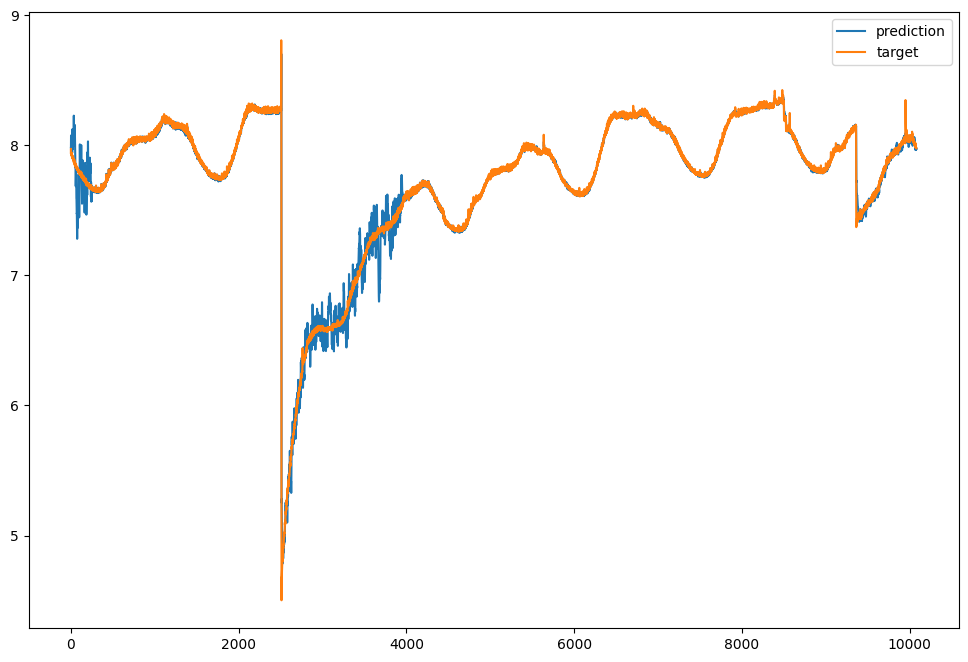

In [14]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')
axes.plot(np.arange(1,10081),target,label='target')
axes.legend()

In [15]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
score=SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target))*100
print('SMAPE',score.item(),'%')

SMAPE 0.387911856174469 %


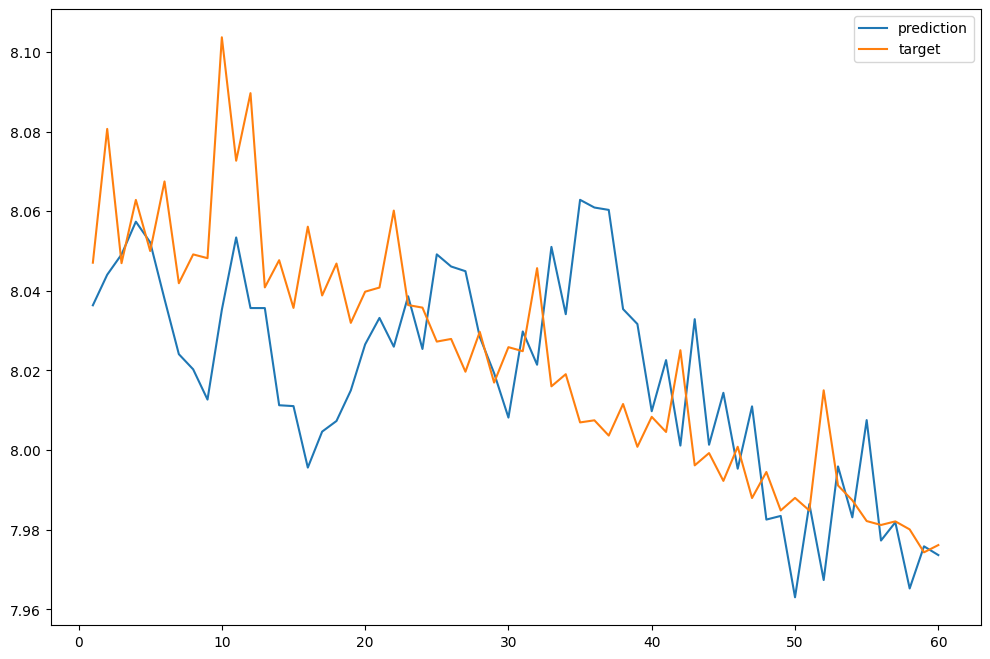

In [16]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

In [17]:
np.mean(time_list)

0.3917019388032338